### 安裝相關套件

In [1]:
!pip install -r requirements.txt

### import 套件

In [2]:
import configparser
import os
import torch
from dataset import LinkPredictionDataset, sample_friend_pairs
from model import Pipeline
from utils import compute_rank_error
from tqdm import tqdm
from main import RandomWalkWithRestart, SimulatedAnnealing, RuleBase

c:\Users\larry\OneDrive - 國立成功大學 National Cheng Kung University\大四\大四下\資料探勘\SNA-make-friend\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the setting file
read the setting file

In [3]:
# read from setting file
configs = configparser.ConfigParser()
configs.read('setting.ini')

['setting.ini']

讀取訓練參數、資料集參數、演算法參數

In [4]:
# load the training setting parameters
model_name = configs["LP Parameter"]["model-name"]
hidden_size = int(configs['LP Parameter']['hidden-size'])
lr = float(configs['LP Parameter']['learning-rate'])
epochs = int(configs["LP Parameter"]['epoch'])

# load the dataset settings
filepath = os.path.join(configs["Task Setting"]["entry"], "combined-adj-sparsefeat.pkl")
test_ratio = float(configs["Task Setting"]["test-ratio"])
seed = int(configs["Reproduce"]["seed"])
count = int(configs["Task Setting"]["friend-sample-count"])
max_alter_count = int(configs["Task Setting"]["max-alter-count"])

# load algorithm parameter
restart_ratio = float(configs['Random Walk']['restart-ratio'])
epsilon = float(configs["Random Walk"]["epsilon"])
walk_graph = configs["Random Walk"]["walk-graph"]

### 訓練推薦系統

In [5]:
# create dataset
link_prediction_ds = LinkPredictionDataset(filepath, seed)
# build up pipeline
torch.manual_seed( seed )
pipeline = Pipeline(model_name, hidden_size, link_prediction_ds.get_feature_size())
# split the dataset before training
ds = link_prediction_ds.split(test_ratio)
train_losses = pipeline.train(ds, lr=lr, epochs=epochs)

100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


AUC: 0.967920


### 繪製訓練過程

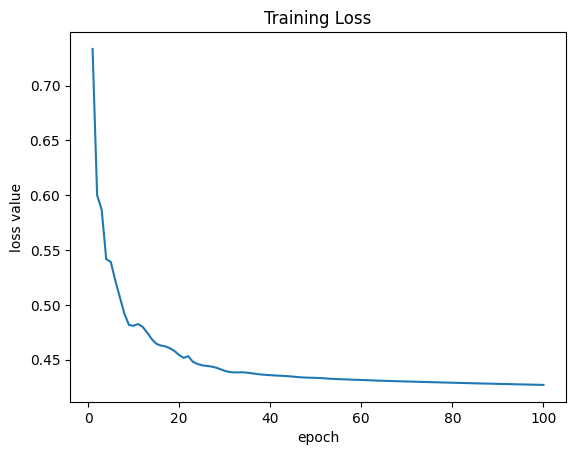

In [6]:
import matplotlib.pyplot as plt

plt.title("Training Loss")
plt.plot(range(1, epochs+1), train_losses)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.show()

隨機採樣friend pairs作為評價調整演算法的基準

In [7]:
future_friend_pairs = sample_friend_pairs(ds, count=count, seed=seed)

定義調整演算法
* RuleBase
* Random Walk with Restart
* Simulated Annealing

In [8]:
start_temp = int(configs["Simulated Annealing"]["start-temp"])
end_temp = int(configs["Simulated Annealing"]["end-temp"])
max_iter = int(configs["Simulated Annealing"]["max-iter"])
cooling_rate = float(configs["Simulated Annealing"]["cooling-rate"])

# method = RandomWalkWithRestart(restart_ratio, max_alter_count, walk_graph, epsilon)
method = SimulatedAnnealing(
    start_temp=start_temp, end_temp=end_temp, max_iter=max_iter,
    cooling_rate=cooling_rate, answer_size=max_alter_count,
    seed=seed
)

### 測試程式

In [9]:
origin_ranks, new_ranks = [], []

with tqdm(total=count, desc="Total Progress", position=0) as outer_progress:
    for pair in future_friend_pairs:
        src, tgt = pair
        g = method.fit(ds["train_g"], pair)
        
        # change new graph to dataset
        link_prediction_ds.set_new_graph(g)
        # split the dataset before training
        ds = link_prediction_ds.split(test_ratio, pairs=future_friend_pairs)

        # build up pipeline
        torch.manual_seed( seed )
        new_pipeline = Pipeline(model_name, hidden_size, link_prediction_ds.get_feature_size())
        new_pipeline.train(ds, lr, epochs, outer_progress)

        # get new rank
        origin_ranks.append( pipeline.predict_rank(ds["train_g"], src, tgt) )
        new_ranks.append( new_pipeline.predict_rank(ds["train_g"], src, tgt) )
    
# output the score
print( compute_rank_error(origin_ranks, new_ranks) )

Total Progress:   0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'DGLGraph' object has no attribute 'shape'